In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from tools import Modelisation, datasets

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X_quant_cat : 63


# Decision tree
## Variables quantitatives

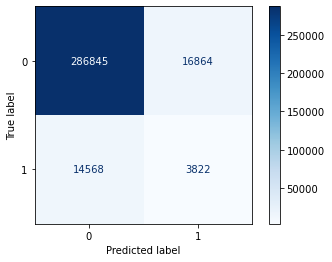

f1 : 0.1956
recall : 0.2078
negative predictive value : 0.9517
precision : 0.1848
roc_auc : 0.5762


In [4]:
m = Modelisation(X_quant, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

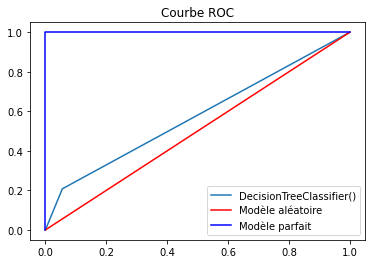

In [5]:
m.show_ROC()

In [6]:
m.show_attributes()

max_depth : 55
n_leaves : 92111
node_count : 184221


C:\Users\pasqu\Informatique\statapp\tools.py:89: RuntimeWarning: invalid value encountered in longlong_scalars
  Precision = TP/(TP+FP)


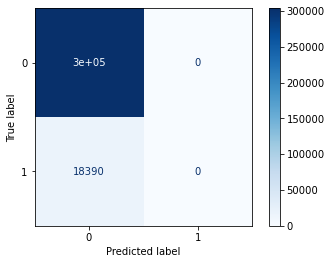

f1 : nan
recall : 0.0000
negative predictive value : 0.9429
precision : nan
roc_auc : 0.7343


In [7]:
m = Modelisation(X_quant, y, DecisionTreeClassifier(max_depth=2))
m.show_conf_matrix()
m.show_metrics_score()

In [8]:
m.show_attributes()

max_depth : 2
n_leaves : 4
node_count : 7


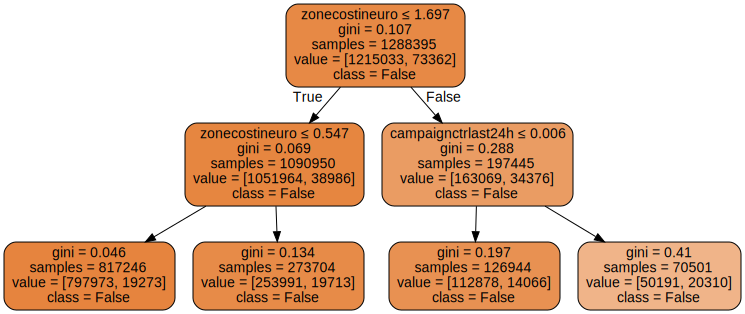

In [9]:
m.plot_tree()

## Variables catégorielles

In [10]:
# Nombre de valeurs distinctes
for column in columns_cat:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7
hour : 24
weekday : 7


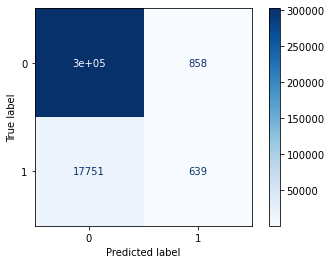

f1 : 0.0643
recall : 0.0347
negative predictive value : 0.9446
precision : 0.4269
roc_auc : 0.6527


In [11]:
m = Modelisation(X_cat, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

In [12]:
m.show_attributes()

max_depth : 47
n_leaves : 19822
node_count : 39643


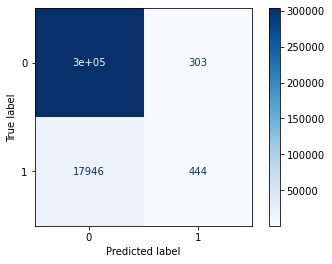

f1 : 0.0464
recall : 0.0241
negative predictive value : 0.9442
precision : 0.5944
roc_auc : 0.6744


In [13]:
m = Modelisation(X_cat, y, DecisionTreeClassifier(max_depth=5))
m.show_conf_matrix()
m.show_metrics_score()

In [14]:
m.show_attributes()

max_depth : 5
n_leaves : 32
node_count : 63


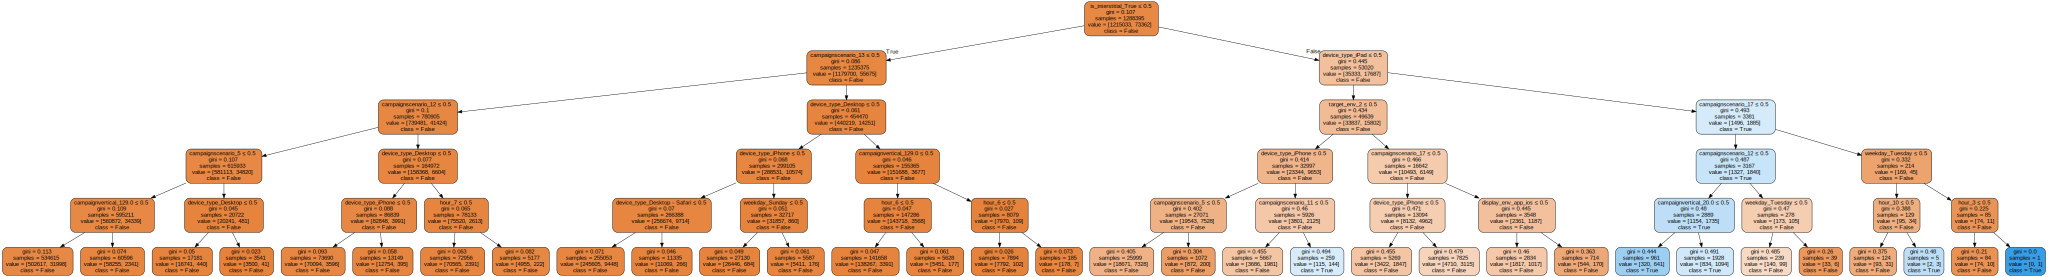

In [15]:
m.plot_tree()

## Variables quantitatives + catégorielles

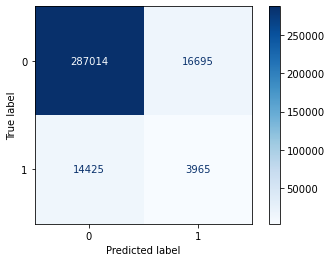

f1 : 0.2031
recall : 0.2156
negative predictive value : 0.9521
precision : 0.1919
roc_auc : 0.5804
Wall time: 38.3 s


In [16]:
%%time
m = Modelisation(X, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

In [17]:
m.show_attributes()

max_depth : 53
n_leaves : 87753
node_count : 175505


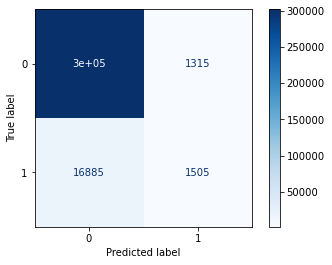

f1 : 0.1419
recall : 0.0818
negative predictive value : 0.9471
precision : 0.5337
roc_auc : 0.7811


In [18]:
m = Modelisation(X, y, DecisionTreeClassifier(max_depth=4))
m.show_conf_matrix()
m.show_metrics_score()

In [19]:
m.show_attributes()

max_depth : 4
n_leaves : 16
node_count : 31


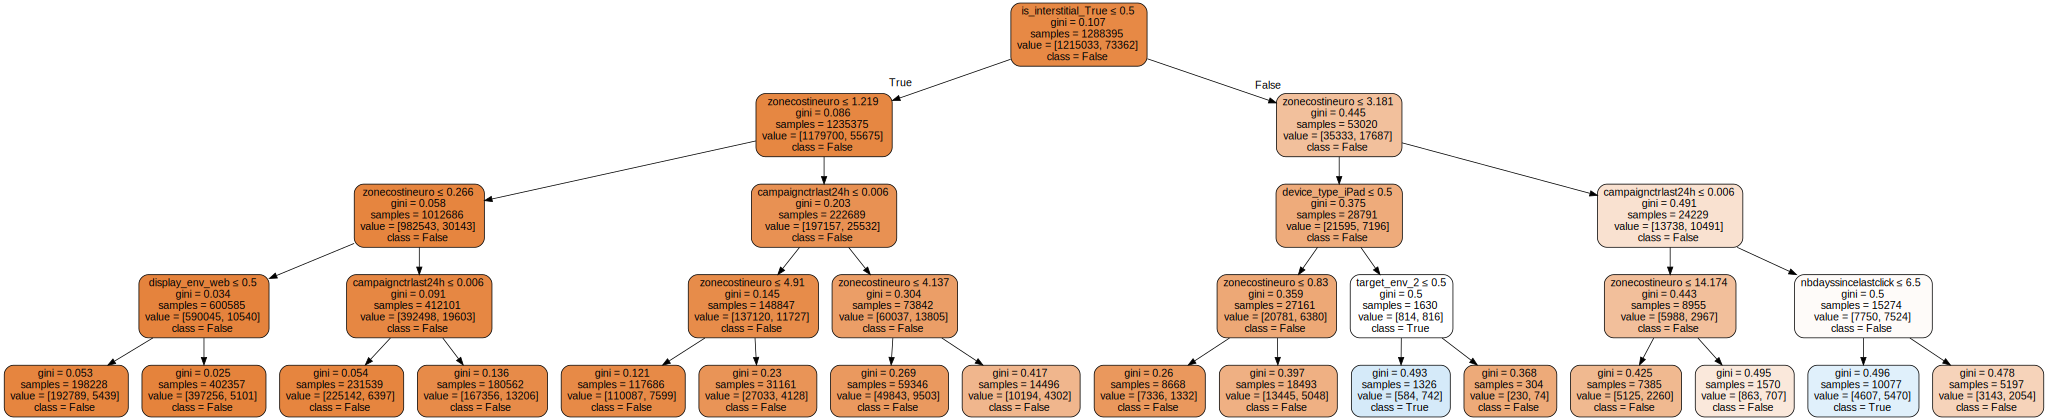

In [20]:
m.plot_tree()

# Random Forest

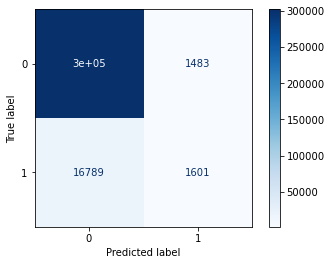

f1 : 0.1491
recall : 0.0871
negative predictive value : 0.9474
precision : 0.5191
roc_auc : 0.7361
Wall time: 20.6 s


In [21]:
%%time
m = Modelisation(X, y, RandomForestClassifier(n_estimators=10, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

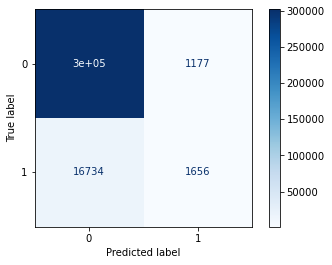

f1 : 0.1561
recall : 0.0900
negative predictive value : 0.9476
precision : 0.5845
roc_auc : 0.8126
Wall time: 2min 52s


In [22]:
%%time
m = Modelisation(X, y, RandomForestClassifier(n_estimators=100, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

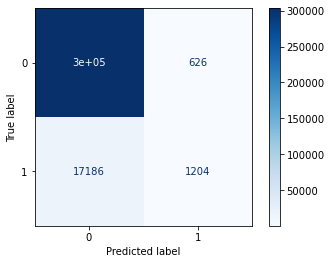

f1 : 0.1191
recall : 0.0655
negative predictive value : 0.9463
precision : 0.6579
roc_auc : 0.8339
Wall time: 2min 47s


In [23]:
%%time
m = Modelisation(X, y, RandomForestClassifier(min_samples_leaf=15, n_estimators=100, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

In [24]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:07:53
